# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

from sklearn import metrics 

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))


In [5]:
data.shape

(891, 11)

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
data.groupby('Sex')['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [7]:
data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


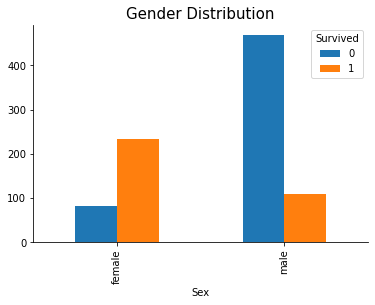

In [8]:
ax = data.groupby('Sex')['Survived'].value_counts().unstack().plot(kind='bar', stacked=False);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Gender Distribution', fontsize=15);

In [9]:
# Number of survived passengers younger than 13 years 
#(I count them as kids as at the beginning of XXc it was their legal status)

boys = len(data[(data['Survived'] == 1) & (data['Sex']=='male')&(data['Age'] < 13)])
girls = len(data[(data['Survived'] == 1) & (data['Sex']=='female')&(data['Age'] < 13)])

In [10]:
print(f'There\'s {boys} boys and {girls} girls among survived underaged passengers.')

There's 21 boys and 19 girls among survived underaged passengers.


#### < your thoughts >

#### There's 314 females (233 survived, which is 74% survival rate) and 577 males (only 109 survived it's 18% survival rate) in dataset. Moreover, among 109 males there's 21 underaged boys, thus only every 6th adult male had a chance to survive. 

Thus we can see a strong relation between gender and survival chance - female had a bigger chance to survive during a shipwreck probaply because of the long-stated ago rule 'Women and children first'. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

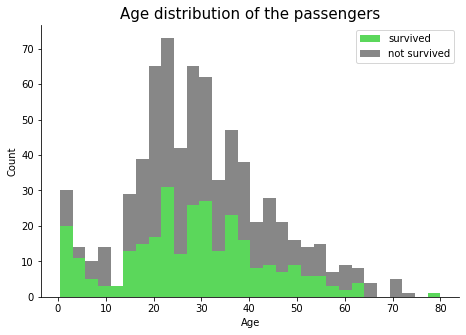

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['survived', 'not survived']
colors = ['limegreen', 'dimgrey']
ax1 = data[data['Survived'] == 1]['Age']
ax2 = data[data['Survived'] == 0]['Age']
plt.hist([ax1, ax2], bins = 30, color = colors, alpha=0.8, label=names, stacked=True)

plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution of the passengers', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [12]:
average_survived = data[data['Survived'] == 1]['Age'].mean()
average_died = data[data['Survived'] == 0]['Age'].mean()
print(f'Average survived was {round(average_survived)} years old.')
print(f'Average deceased was {round(average_died)} years old.')
median_survived = data[data['Survived'] == 1]['Age'].median()
median_died = data[data['Survived'] == 0]['Age'].median()
print(f'Median survived was {round(median_survived)} years old.')
print(f'Median deceased was {round(median_died)} years old.')

Average survived was 28 years old.
Average deceased was 31 years old.
Median survived was 28 years old.
Median deceased was 28 years old.


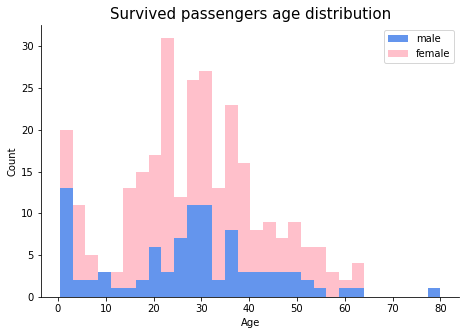

In [13]:
# Let's look at sex distribution of survived passengers and their age

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['male', 'female']
colors = ['cornflowerblue', 'pink']
ax1 = data[(data['Survived'] == 1) & (data['Sex']=='male')]['Age']
ax2 = data[(data['Survived'] == 1) & (data['Sex']=='female')]['Age']
plt.hist([ax1, ax2], bins = 30, color = colors, alpha=1, label=names, stacked=True)

plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Survived passengers age distribution', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

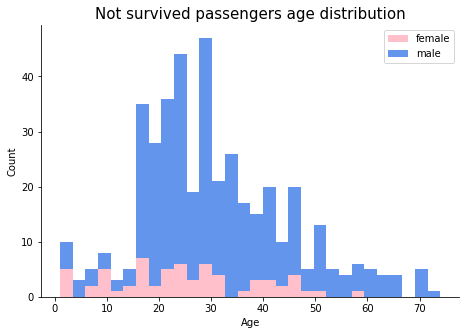

In [14]:
# Do the same for their less lucky fellow travelers

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['female', 'male']
colors = ['pink', 'cornflowerblue']
ax1 = data[(data['Survived'] == 0) & (data['Sex']=='female')]['Age']
ax2 = data[(data['Survived'] == 0) & (data['Sex']=='male')]['Age']
plt.hist([ax1, ax2], bins = 30, color = colors, alpha=1, label=names, stacked=True)

plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Not survived passengers age distribution', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### < your thoughts >

Age distributions don't really differ for survived and deceased passengers, except for average 28 for survived and 31 for deceased. As you may see at histograms above, the majority of survived were females who are at the same time were slightly younger than male passengers. In contrary, the most of deceased passengers were males, who in general were older, that's why we see this 3 years gap. At the same time we can see, that underage passengers had pretty good chance to survive.

Overall age doesn't look like determining feature responsible for increasing surviving chance as it's for sex. 

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [15]:
data[['Pclass', 'Survived']].groupby(['Pclass'], 
                                     as_index=False).mean().sort_values(by='Survived', ascending=False) 

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


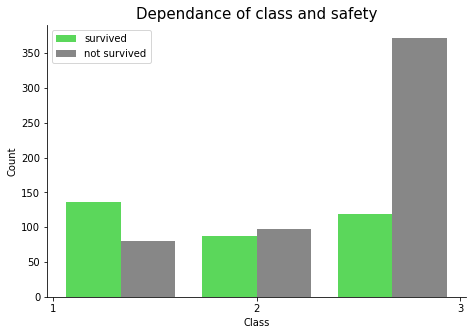

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['survived', 'not survived']
colors = ['limegreen', 'dimgrey']
ax1 = data[(data['Survived'] == 1)]['Pclass']
ax2 = data[(data['Survived'] == 0)]['Pclass']
plt.hist([ax1, ax2], bins = 3, color = colors, alpha=0.8, label=names, stacked=False)

plt.legend()
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Dependance of class and safety', fontsize=15)

ax.locator_params(integer=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [17]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Looks like 1st class was the safest since it has the highest survival rate - 63%. Although 2d class passengers also had reltively good chance to survive (almost 1:1) compare to absolute worst situation for 3rd class passengers, which was the most crowded at the same time.  

In [18]:
data['Embarked'].fillna(value='S', inplace=True)

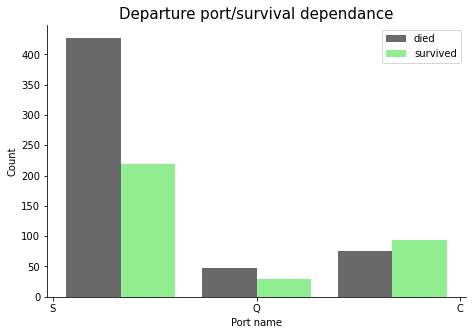

In [19]:
# Let's see which departure port was the safest

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['died', 'survived']
colors = ['dimgrey', 'lightgreen']
ax1 = data[(data['Survived'] == 0)]['Embarked']
ax2 = data[(data['Survived'] == 1)]['Embarked']
plt.hist([ax1, ax2], bins = 3, color = colors, alpha=1, label=names, stacked=False)

plt.legend()
plt.xlabel('Port name')
plt.ylabel('Count')
plt.title('Departure port/survival dependance', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

At first glance it looks like the port C (Cherbourg) is the safest one since more than a half of departured from here had survived. Let's see if there is any pattern between passenger class and departure port (maybe the luckiest 1st class passengers mostly departured from the port C?)

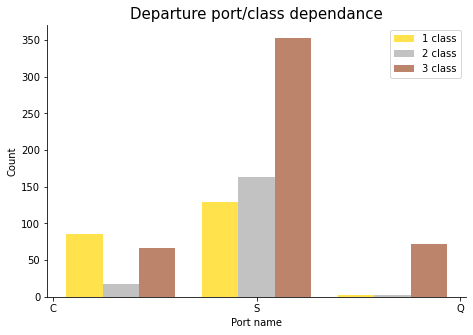

In [20]:
# Class spread over ports

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['1 class', '2 class', '3 class']
colors = ['gold', 'darkgray', 'sienna']
ax1 = data[(data['Pclass'] == 1)]['Embarked']
ax2 = data[(data['Pclass'] == 2)]['Embarked']
ax3 = data[(data['Pclass'] == 3)]['Embarked']
plt.hist([ax1, ax2, ax3], bins = 3, color = colors, alpha=.7, label=names, stacked=False)

plt.legend()
plt.xlabel('Port name')
plt.ylabel('Count')
plt.title('Departure port/class dependance', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

As we can see from the above, port C really was mostly for the 1st class passengers, at the same time S (Southampton) was the most crowded departure port. 

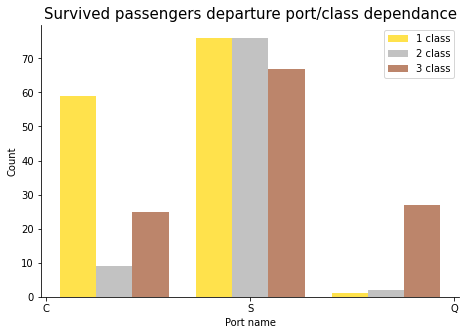

In [21]:
# Examine all survived passengers

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['1 class', '2 class', '3 class']
colors = ['gold', 'darkgray', 'sienna']
ax1 = data[(data['Pclass'] == 1) & (data['Survived']==1)]['Embarked']
ax2 = data[(data['Pclass'] == 2) & (data['Survived']==1)]['Embarked']
ax3 = data[(data['Pclass'] == 3) & (data['Survived']==1)]['Embarked']
plt.hist([ax1, ax2, ax3], bins = 3, color = colors, alpha=.7, label=names, stacked=False)

plt.legend()
plt.xlabel('Port name')
plt.ylabel('Count')
plt.title('Survived passengers departure port/class dependance', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

As we can see, survived 1st class passengers spread almost evenly between ports C and S and make the majority there. Interesting moment -  at S we can see even some kind of equality in absolute numbers between different classes passengers, but percentages are just horrible - survived only 20% of 3rd class passengers departured from port S, meanvile it's 58% for 3rd class and 46% for 2nd class.

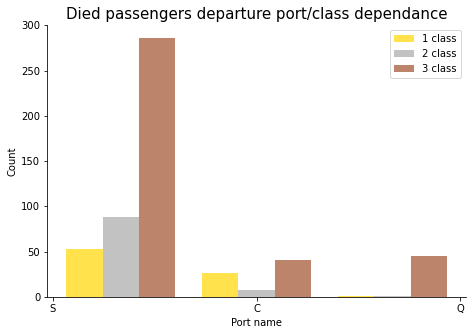

In [22]:
# Passengers died

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
names = ['1 class', '2 class', '3 class']
colors = ['gold', 'darkgray', 'sienna']
ax1 = data[(data['Pclass'] == 1) & (data['Survived']==0)]['Embarked']
ax2 = data[(data['Pclass'] == 2) & (data['Survived']==0)]['Embarked']
ax3 = data[(data['Pclass'] == 3) & (data['Survived']==0)]['Embarked']
plt.hist([ax1, ax2, ax3], bins = 3, color = colors, alpha=.7, label=names, stacked=False)

plt.legend()
plt.xlabel('Port name')
plt.ylabel('Count')
plt.title('Died passengers departure port/class dependance', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

< your thoughts >

In [23]:
data[['Embarked','Survived']].groupby(['Embarked'], 
                                      as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Pors C in general had higher percentage of survived passengers, but as we can see from plot from the above, it's not because it somehow was safer, but it was mostrly for 1st and 2nd class passengers. In general we can still see that the crucial survival factor is passenger class - more likely to get into a rescue boat if you are the 1st class traveler. In all cases we can see that 1st classes have priopity right to be saved, but if I still need to choose 'the safest' port I'd pick C according to the numbers.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [24]:
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.000000
dtype: float64

In [25]:
test.isnull().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

####  < your thoughts >

Age - less than 20% is missed in both train and test, we could just drop them, but since our dataset is quite small, I won't do so. 2st option is to fill missing data with average value, wich is not prefferable, bacause it can distort model quality. I choose 3rd option - fill missing values with extracted from Name honorific title and find average for it.
Embarked - it had only 2 missing values, so I simply filled them with the most popular port - S.
Fare - small amount, we can fill it with average for passenger class.
Cabin - 78& and 77% missed values, the first thought is to drop this column, but again, dataset is small so I prefer to keep as many features as possible, so I probably try to exctract the floor name from it.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

#### Preprocessing data
filling missing data
#### Age

In [26]:
def get_honorific(string):
    
    #Extract honorific title from name
    string = string.split(' ')
    if string[1] == 'Miss.':
        return 'Miss.'
    elif string[1] == 'Mr.':
        return 'Mr.'
    elif string[1] == 'Master.':
        return 'Master.'
    elif string[1] == 'Mrs.':
        return 'Mrs.'
    else:
        return 'Noble'

# Create Honorific column
data['Honorific'] = data['Name'].apply(get_honorific)
data['Honorific'].value_counts()

# Average age for each group
honorific = ["Master.", "Miss.", "Mrs.", "Mr.", "Noble"]
ages = []
for i in range(len(honorific)):
    ages.append(round(data[data["Honorific"] == honorific[i]]["Age"].mean()))
    print(f'For {honorific[i]} average age is {round(data[data["Honorific"] == honorific[i]]["Age"].mean())}.')
 
def fill_na(string):
    if 0 < string <100:
        return string
    else:
        return 0
    
data['Age'] = data['Age'].apply(fill_na)

for i in range(len(ages)):
    data.loc[(data['Age']==0) & (data['Honorific']==honorific[i]),'Age'] = ages[i]
    
data['Age'].isnull().sum()

For Master. average age is 5.
For Miss. average age is 22.
For Mrs. average age is 36.
For Mr. average age is 32.
For Noble average age is 37.


0

#### Cabin

In [27]:
def get_cabin(string):
    
    # Extract the deck letter, combine them (A - E for 1st 2nd Class,  F, G - 3rd Class) 
    string = str(string).upper()
    if string == 'NAN':
        return 0
    if string[0] == 'A' or string[0] == 'B' or string[0]== 'C':
        return 1
    elif string[0] == 'D' or string[0] == 'E':
        return 1
    elif string[0] == 'F' or string[0] == 'G':
        return 0
    else:
        return 0

data['Cabin'].fillna(value=0, inplace=True)
test['Cabin'].fillna(value=0, inplace=True)    
data['Cabin_class'] = data['Cabin'].apply(get_cabin)
data['Cabin_class'].value_counts()


0    705
1    186
Name: Cabin_class, dtype: int64

#### Missing data for test

In [28]:
# Extract 'Honorific'
test['Honorific'] = test['Name'].apply(get_honorific)

# Transform 'Cabin'
test['Cabin_class'] = test['Cabin'].apply(get_cabin)

# Average age for each group
honorific = ["Master.", "Miss.", "Mrs.", "Mr.", "Noble"]
ages = []
for i in range(len(honorific)):
    ages.append(round(test[test["Honorific"] == honorific[i]]["Age"].mean()))
    print(f'For {honorific[i]} average age is {round(test[test["Honorific"] == honorific[i]]["Age"].mean())}.')
test['Age'] = test['Age'].apply(fill_na)

# Fill missing 'Age' values according to 'Honorific' status
for i in range(len(ages)):
    test.loc[(test['Age']==0) & (test['Honorific']==honorific[i]),'Age'] = ages[i]

# Fill missing 'Fare'
test['Fare'].fillna(value=96, inplace=True)
test.loc[(test['Fare']==0) & (test['Pclass']==1),'Fare'] = 96

For Master. average age is 7.
For Miss. average age is 22.
For Mrs. average age is 39.
For Mr. average age is 32.
For Noble average age is 35.


### Modeling #1

In [29]:
data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Honorific', 'Cabin_class'],
      dtype='object')

In [30]:
features = ['Pclass',  'Age', 'SibSp', 'Parch', 
            'Fare', 'Cabin_class']

In [31]:
X_train = data[features]
y_train = data.Survived
X_test = test[features]

In [32]:
def models(X_train, y_train):
    
    #Logistic Regression
    log = LogisticRegression(solver='liblinear', penalty='l2', random_state=42)
    log.fit(X_train, y_train)
    print(log)
    print(metrics.classification_report(y_train, log.predict(X_train)))
    print(metrics.confusion_matrix(y_train, log.predict(X_train)))
    print('Result after CV {:f}'.format(
        cross_val_score(log, X_train, y_train, scoring='accuracy', cv=10).mean()))
    
    print('')
    # KNN
          
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
    knn.fit(X_train, y_train)
    print(knn)
    print(metrics.classification_report(y_train, knn.predict(X_train)))
    print(metrics.confusion_matrix(y_train, knn.predict(X_train)))
    print('Result after CV {:f}'.format(
        cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10).mean()))
          
    return log, knn

In [33]:
model = models(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       549
           1       0.71      0.46      0.56       342

    accuracy                           0.72       891
   macro avg       0.72      0.67      0.68       891
weighted avg       0.72      0.72      0.71       891

[[486  63]
 [184 158]]
Result after CV 0.710512

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       549
           1       0.75      0.70      0.72       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.79      0.80      0.79       891

[[471  78]
 [104 238]]
Result after CV 0.692522


We took a few features for modeling and got 0.71 accuracy for default LogReg model and 0.69 accuracy for default KNN. It can be better.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

### Modeling #2
further  feature engineering

#### Create cross features
I want to join Age and Class features, to make some synthetic features.


In [34]:
data['F_1'] = 0         
data['F_2'] = 0
data['F_3'] = 0
data['M_1'] = 0
data['M_2'] = 0
data['M_3'] = 0

test['F_1'] = 0
test['F_2'] = 0
test['F_3'] = 0
test['M_1'] = 0
test['M_2'] = 0
test['M_3'] = 0

In [35]:
data.loc[(data['Sex']=='female') & (data['Pclass']==1),'F_1'] = 1
data.loc[(data['Sex']=='female') & (data['Pclass']==2),'F_2'] = 1
data.loc[(data['Sex']=='female') & (data['Pclass']==3),'F_3'] = 1
data.loc[(data['Sex']=='male') & (data['Pclass']==1),'M_1'] = 1
data.loc[(data['Sex']=='male') & (data['Pclass']==2),'M_2'] = 1
data.loc[(data['Sex']=='male') & (data['Pclass']==3),'M_3'] = 1
test.loc[(test['Sex']=='female') & (test['Pclass']==1),'F_1'] = 1
test.loc[(test['Sex']=='female') & (test['Pclass']==2),'F_2'] = 1
test.loc[(test['Sex']=='female') & (test['Pclass']==3),'F_3'] = 1
test.loc[(test['Sex']=='male') & (test['Pclass']==1),'M_1'] = 1
test.loc[(test['Sex']=='male') & (test['Pclass']==2),'M_2'] = 1
test.loc[(test['Sex']=='male') & (test['Pclass']==3),'M_3'] = 1

#### Family
Show if passenger traveled alone or with family

In [36]:
data['Trav_family'] = 0
data['Trav_alone'] = 0
test['Trav_family'] = 0
test['Trav_alone'] = 0
data.loc[(data['SibSp']!=0) | (data['Parch']!=0),'Trav_family'] = 1
data.loc[(data['SibSp']==0) & (data['Parch']==0),'Trav_alone'] = 1
test.loc[(test['SibSp']!=0) | (test['Parch']!=0),'Trav_family'] = 1
test.loc[(test['SibSp']==0) & (test['Parch']==0),'Trav_alone'] = 1


#### Fare
Divide fare to cheap - expensive

In [37]:
data.loc[(data['Survived']==1),'Fare'].describe()

count    342.000000
mean      48.395408
std       66.596998
min        0.000000
25%       12.475000
50%       26.000000
75%       57.000000
max      512.329200
Name: Fare, dtype: float64

In [38]:
data['F_cheap'] =0
data['F_mid'] = 0
data['F_expens'] = 0
test['F_cheap'] = 0
test['F_mid'] = 0
test['F_expens'] = 0
data.loc[(data['Fare'] <= 13),'F_cheap'] = 1
data.loc[(data['Fare'] > 13) & (data['Fare'] <= 70),'F_mid'] = 1
data.loc[(data['Fare'] > 70),'F_expens'] = 1
test.loc[(test['Fare'] <= 13),'F_cheap'] = 1
test.loc[(test['Fare'] > 13) & (test['Fare'] <= 70),'F_mid'] = 1
test.loc[(test['Fare'] > 70),'F_expens'] = 1

#### Age
Group passengers according Age

In [39]:
data['Kid'] = 0
data.loc[(data['Age'] <= 13),'Kid'] = 1
test['Kid'] = 0
test.loc[(test['Age'] <= 13),'Kid'] = 1

#### Embarked

In [40]:
data = pd.get_dummies(data, columns=["Embarked"])
test = pd.get_dummies(test, columns=["Embarked"])

### 2nd Model


In [41]:
features = ['Age', 'SibSp', 'Parch',
            'Fare', 'Honorific', 'Cabin_class', 'F_1', 'F_2',
            'F_3', 'M_1', 'M_2', 'M_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
            'Trav_family', 'Trav_alone', 'F_cheap', 'F_mid', 'F_expens', 'Kid']

In [42]:
def models_2(X_train, y_train):
    
    #Logistic Regression
    log = LogisticRegression(solver='liblinear', penalty='l2', random_state=42)
    log.fit(X_train, y_train)
    print(log)
    print(metrics.classification_report(y_train, log.predict(X_train)))
    print(metrics.confusion_matrix(y_train, log.predict(X_train)))
    print('Result after CV {:f}'.format(
        cross_val_score(log, X_train, y_train, scoring='accuracy', cv=10).mean()))
    
    print('')
    # KNN
          
    knn = KNeighborsClassifier(n_neighbors=28, metric='minkowski', p=2)
    knn.fit(X_train, y_train)
    print(knn)
    print(metrics.classification_report(y_train, knn.predict(X_train)))
    print(metrics.confusion_matrix(y_train, knn.predict(X_train)))
    print('Result after CV {:f}'.format(
        cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=20).mean()))
          
    return log, knn

In [43]:
X_train = pd.get_dummies(data[features])
y_train = data.Survived
X_test = pd.get_dummies(test[features])

In [44]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)

In [45]:
model = models_2(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.84      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.85      0.83      0.83       891
weighted avg       0.85      0.85      0.85       891

[[500  49]
 [ 87 255]]
Result after CV 0.836167

KNeighborsClassifier(n_neighbors=28)
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       549
           1       0.71      0.50      0.59       342

    accuracy                           0.73       891
   macro avg       0.72      0.69      0.69       891
weighted avg       0.73      0.73      0.72       891

[[480  69]
 [171 171]]
Result after CV 0.717525


In [46]:
submit = model[0].predict(X_test)

### Submission


In [47]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = submit   # predict here
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [48]:
# If you want you can submit my prediction to Kaggle, uncomment the line bollow

if len(test) == len(submit):
    print('OK')
    #submission.to_csv('Bochkareva_submission.csv', index=False)            #THIS ONE
else:
    print('Error: test and submission different len')

OK


## Kaggle Result

For submission I choosed the final LogReg model with accuracy (CV) score = 0.836167, which is Kaggle score = 0.78468.

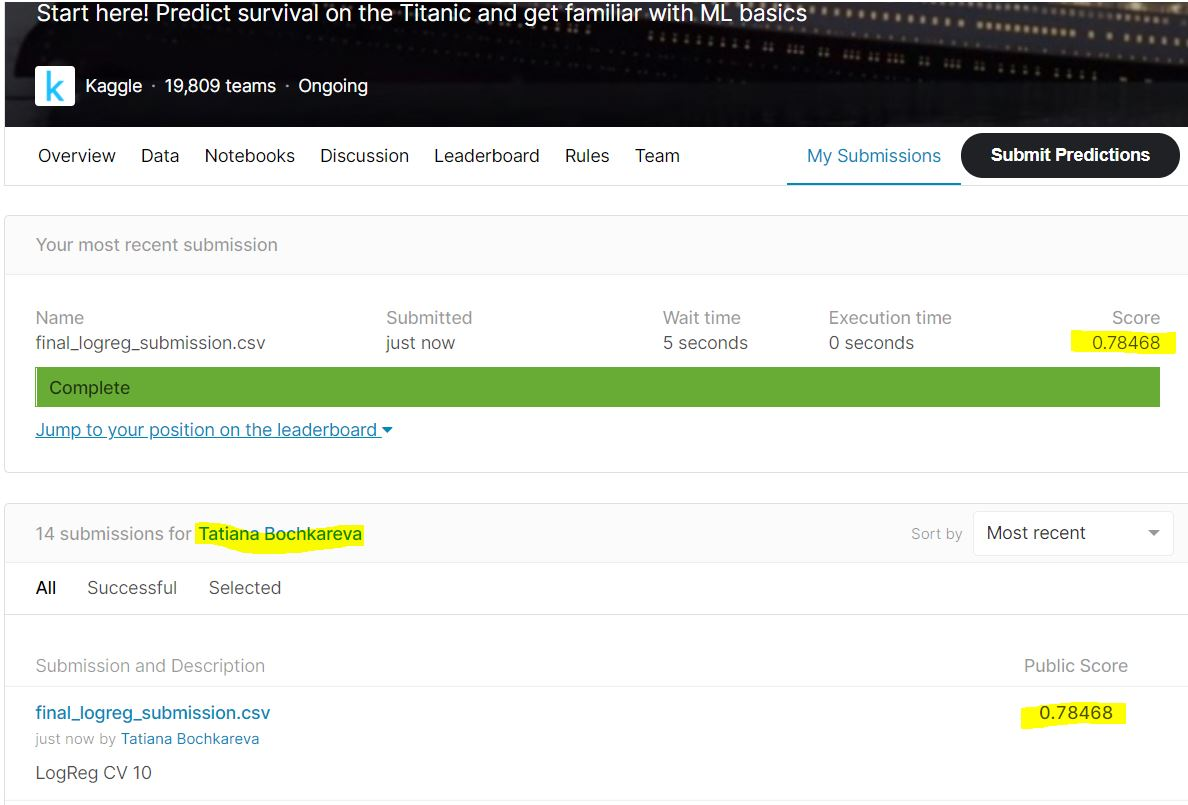

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

To sum up, creating extra cross features helped me a lot to improve the model accuracy, I also tried different features combinations, changing CV and n_neibours numbers, meanwile during tests scaling didn't help me fr Logistic Regression, but improved KNN model (but it was still lower than LogReg). So the final model above gave me the best result.

#### Tnaks for your time!


#### My Kaggle https://www.kaggle.com/tatianabochkareva
